In [1]:
from google.colab import drive
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import matplotlib.pyplot as plt
import numpy as np
from nltk import FreqDist
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from itertools import chain
import re



# Configuration

In [2]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
drive.mount("/drive", force_remount=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Mounted at /drive


# Preparation

In [3]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
# add the punctuations you want to remove here
punctuation = string.punctuation + '“”’'

def tokenize(text):
  return word_tokenize(text)

def lower(tokens):
  return [t.lower() for t in tokens]

def alpha(tokens):
  return [t for t in tokens if t.isalpha()]

def no_stopwords(tokens):
  return [t for t in tokens if t not in stop_words]

def lemmatize(tokens):
  return [lemmatizer.lemmatize(t) for t in tokens]

def pos_tag(tokens):
  return nltk.pos_tag(tokens)

def bigram_filter(bigrams):
  # return False if any token in the bigram include punctuations or stopwords or non-alphabetical characters
  pattern = re.compile('^[^a-z]+$')
  return not any([(bi in punctuation or bi in stop_words or pattern.match(bi)) for bi in bigrams])



In [4]:
# Load the True and Fake datasets
true_df = pd.read_csv('/drive/My Drive/Colab Notebooks/IST 664/2023/True.csv')
fake_df = pd.read_csv('/drive/My Drive/Colab Notebooks/IST 664/2023/Fake.csv')

In [5]:
true_df['tokens'] = true_df['text'].apply(tokenize)
fake_df['tokens'] = fake_df['text'].apply(tokenize)


In [6]:
true_df['lemma_tokens'] = true_df['tokens'].apply(lower).apply(lemmatize)
fake_df['lemma_tokens'] = fake_df['tokens'].apply(lower).apply(lemmatize)

# Descriptive Stats

In [7]:
def top_unigram(df, col="lemma_tokens", top_k=50):
  tokens = df[col].values
  print("analyzing stopwords .......")
  total_stop_words = [t for t in list(chain.from_iterable(tokens)) if t in stop_words]
  top_stop_words = FreqDist(total_stop_words).most_common(50)

  print("analyzing content words .......")
  total_content_words = [t for t in list(chain.from_iterable(tokens)) if (t not in stop_words and t not in punctuation)]
  top_content_words = FreqDist(total_content_words).most_common(50)

  print("analyzing adjectives words .......")
  total_adjectives = [t for t in list(chain.from_iterable(df[col].apply(pos_tag))) if (t[1] == 'JJ' and t[0] not in punctuation)]
  top_adjectives = FreqDist(total_adjectives).most_common(50)

  return top_stop_words, top_content_words, top_adjectives

def top_bigram(df, col="tokens", top_k=50):
  tokens = df[col].apply(lower)

  finder = BigramCollocationFinder.from_words(list(chain.from_iterable(tokens)))
  bigram_measures = BigramAssocMeasures()
  freq_scores = finder.score_ngrams(bigram_measures.raw_freq)

  finder.apply_freq_filter(5)
  mi_scores = finder.score_ngrams(bigram_measures.mi_like)

  top_bigrams_by_freq = sorted(freq_scores, key=lambda x: x[-1], reverse=True)[:50]
  top_bigrams_by_mi = sorted(mi_scores, key=lambda x: x[-1], reverse=True)[:50]

  top_filtered_bigrams_by_freq = [(bigram, freq) for bigram, freq in top_bigrams_by_freq if bigram_filter(bigram)]
  top_filtered_bigrams_by_mi = [(bigram, mi) for bigram, mi in top_bigrams_by_mi if bigram_filter(bigram)]

  return top_bigrams_by_freq, top_bigrams_by_mi, top_filtered_bigrams_by_freq, top_filtered_bigrams_by_mi



In [8]:
true_top_stop_words, true_top_content_words, true_top_adjectives = top_unigram(true_df)

analyzing stopwords .......
analyzing content words .......
analyzing adjectives words .......


In [9]:
fake_top_stop_words, fake_top_content_words, fake_top_adjectives = top_unigram(fake_df)

analyzing stopwords .......
analyzing content words .......
analyzing adjectives words .......


## stopwords stats

In [10]:
print(f"top common stopwords in true articles: {true_top_stop_words}")
print(f"top common stopwords in fake articles: {fake_top_stop_words}")

top common stopwords in true articles: [('the', 482176), ('a', 245167), ('to', 245125), ('of', 204959), ('and', 181686), ('in', 180675), ('on', 108346), ('s', 99905), ('that', 88116), ('for', 79730), ('it', 70683), ('is', 55439), ('with', 54485), ('he', 54368), ('by', 47637), ('from', 39376), ('his', 38016), ('not', 37594), ('have', 36415), ('be', 34297), ('at', 33164), ('an', 32710), ('who', 27642), ('but', 26596), ('are', 26127), ('had', 25672), ('will', 25257), ('we', 22163), ('they', 22064), ('this', 21025), ('which', 20809), ('been', 19600), ('after', 19375), ('were', 18916), ('about', 17425), ('more', 17200), ('i', 17020), ('their', 16826), ('or', 15107), ('over', 13841), ('some', 12752), ('if', 12538), ('she', 11721), ('there', 11642), ('other', 11581), ('than', 11299), ('against', 10999), ('up', 10971), ('no', 10757), ('out', 10560)]
top common stopwords in fake articles: [('the', 528689), ('to', 289665), ('a', 267070), ('of', 235806), ('and', 224544), ('in', 164871), ('that', 

## content words stats

In [11]:
print(f"top common content words in true articles: {true_top_content_words}")
print(f"top common content words in fake articles: {fake_top_content_words}")

top common content words in true articles: [('said', 99037), ('trump', 54280), ('wa', 48027), ('ha', 46259), ('u.s.', 36970), ('state', 36243), ('would', 31526), ('reuters', 28412), ('president', 26939), ('republican', 22098), ('government', 19433), ('year', 18721), ('house', 16906), ('new', 16784), ('also', 15946), ('united', 15576), ('people', 15207), ('party', 14964), ('official', 14575), ('told', 14244), ('country', 13948), ('election', 13910), ('could', 13709), ('one', 13025), ('last', 12631), ('washington', 12419), ('two', 11620), ('group', 11104), ('campaign', 11079), ('former', 10601), ('leader', 10504), ('donald', 10447), ('week', 10426), ('security', 10382), ('court', 10338), ('percent', 9937), ('say', 9934), ('north', 9870), ('minister', 9541), ('clinton', 9504), ('white', 9500), ('tax', 9230), ('law', 9221), ('senate', 9206), ('obama', 9197), ('time', 9048), ('vote', 8981), ('month', 8754), ('china', 8564), ('first', 8550)]
top common content words in fake articles: [('trum

## adjectives stats

In [12]:
print(f"top common adjectives in true articles: {true_top_adjectives}")
print(f"top common adjectives in fake articles: {fake_top_adjectives}")


top common adjectives in true articles: [(('u.s.', 'JJ'), 35140), (('s', 'JJ'), 28483), (('republican', 'JJ'), 18943), (('new', 'JJ'), 16784), (('united', 'JJ'), 15412), (('last', 'JJ'), 12631), (('other', 'JJ'), 11581), (('former', 'JJ'), 10601), (('white', 'JJ'), 9500), (('north', 'JJ'), 8656), (('national', 'JJ'), 8534), (('democratic', 'JJ'), 8237), (('foreign', 'JJ'), 8197), (('presidential', 'JJ'), 7979), (('political', 'JJ'), 7699), (('military', 'JJ'), 7435), (('american', 'JJ'), 6812), (('many', 'JJ'), 6721), (('first', 'JJ'), 6450), (('federal', 'JJ'), 6447), (('i', 'JJ'), 6085), (('russian', 'JJ'), 5794), (('nuclear', 'JJ'), 5027), (('next', 'JJ'), 4962), (('public', 'JJ'), 4802), (('international', 'JJ'), 4737), (('conservative', 'JJ'), 4476), (('european', 'JJ'), 4449), (('prime', 'JJ'), 4243), (('economic', 'JJ'), 4086), (('south', 'JJ'), 4064), (('general', 'JJ'), 4054), (('islamic', 'JJ'), 3955), (('senior', 'JJ'), 3938), (('top', 'JJ'), 3882), (('trump', 'JJ'), 3795), 

## bigrams stats

In [13]:
true_top_bigrams_by_freq, true_top_bigrams_by_mi, true_top_filtered_bigrams_by_freq, true_top_filtered_bigrams_by_mi = top_bigram(true_df)

In [14]:
fake_top_bigrams_by_freq, fake_top_bigrams_by_mi, fake_top_filtered_bigrams_by_freq, fake_top_filtered_bigrams_by_mi = top_bigram(fake_df)

In [15]:
print(f"top common bigrams by frequency in true articles before filtering: {true_top_bigrams_by_freq}")
print(f"top common bigrams by frequency in fake articles before filtering: {fake_top_bigrams_by_freq}")


top common bigrams by frequency in true articles before filtering: [(('’', 's'), 0.005893047000520177), (('.', 'the'), 0.005131179672495742), (('of', 'the'), 0.005116053891975967), (('in', 'the'), 0.004400529380863184), (('.', '“'), 0.002925819417704651), ((',', 'the'), 0.0028988933828786676), ((',', '”'), 0.002626736608561857), (('to', 'the'), 0.002386011420715218), (('said', '.'), 0.0023162826452694445), ((')', '-'), 0.002290322085795787), (('reuters', ')'), 0.0022797018569202), (('(', 'reuters'), 0.0022795945818810527), ((',', 'a'), 0.002195490951189535), (('in', 'a'), 0.0019579840145173165), ((',', 'and'), 0.0019333107555134274), (('on', 'the'), 0.0017810874749633469), (('for', 'the'), 0.0016549320289260708), (('the', 'united'), 0.0015203018547961544), ((',', 'which'), 0.0014835065163686155), ((',', 'said'), 0.001475889988589154), (('and', 'the'), 0.0013025335253270467), (('united', 'states'), 0.001296418848095648), ((',', 'who'), 0.001273891089874706), (('trump', '’'), 0.001252328

In [16]:
print(f"top common bigrams by frequency in true articles after filtering: {true_top_filtered_bigrams_by_freq}")
print(f"top common bigrams by frequency in fake articles after filtering: {fake_top_filtered_bigrams_by_freq}")

top common bigrams by frequency in true articles after filtering: [(('united', 'states'), 0.001296418848095648), (('donald', 'trump'), 0.0010832633453098763), (('white', 'house'), 0.0008981066277415612)]
top common bigrams by frequency in fake articles after filtering: [(('donald', 'trump'), 0.0011973377514477232)]


In [17]:
print(f"top common bigrams by mi scores in true articles before filtering: {true_top_bigrams_by_mi}")
print(f"top common bigrams by mi scores in fake articles before filtering: {fake_top_bigrams_by_mi}")

top common bigrams by mi scores in true articles before filtering: [(('’', 's'), 23448.364946554473), (('(', 'reuters'), 9542.400079716312), (('reuters', ')'), 9539.704258437663), ((')', '-'), 8846.936785175942), (('united', 'states'), 6861.284818679724), (('white', 'house'), 3761.7845301663324), (('north', 'korea'), 2497.3420803922522), (('prime', 'minister'), 1917.239268035897), (('donald', 'trump'), 1816.86545425984), (('saudi', 'arabia'), 1219.1867498891677), (('barack', 'obama'), 1202.1110989396916), (('.', '“'), 1194.4387982554026), (('more', 'than'), 1177.3612292793398), (('new', 'york'), 1150.6257616334979), (('of', 'the'), 1097.5813110887905), (('puerto', 'rico'), 1037.8962209556255), (('did', 'not'), 828.7013420531446), (('in', 'the'), 792.3551483532141), (('president', 'donald'), 749.3023748072117), (('.', 'the'), 723.4119460614343), ((',', '”'), 670.9200688744679), (('nov.', '8'), 630.2593677871305), (('washington', '('), 622.7764842395774), (('human', 'rights'), 615.049861

In [18]:
print(f"top common bigrams by mi scores in true articles after filtering: {true_top_filtered_bigrams_by_mi}")
print(f"top common bigrams by mi scores in fake articles after filtering: {fake_top_filtered_bigrams_by_mi}")

top common bigrams by mi scores in true articles after filtering: [(('united', 'states'), 6861.284818679724), (('white', 'house'), 3761.7845301663324), (('north', 'korea'), 2497.3420803922522), (('prime', 'minister'), 1917.239268035897), (('donald', 'trump'), 1816.86545425984), (('saudi', 'arabia'), 1219.1867498891677), (('barack', 'obama'), 1202.1110989396916), (('new', 'york'), 1150.6257616334979), (('puerto', 'rico'), 1037.8962209556255), (('president', 'donald'), 749.3023748072117), (('human', 'rights'), 615.0498613399973), (('supreme', 'court'), 598.3594570937303), (('hillary', 'clinton'), 589.8675307962766), (('told', 'reporters'), 511.37462178135485), (('suu', 'kyi'), 485.0385065716783), (('islamic', 'state'), 480.1517591579879), (('european', 'union'), 476.05271534866483), (('shi', 'ite'), 425.02016953444945), (('hong', 'kong'), 419.6128966274555), (('middle', 'east'), 415.9027060812837), (('pena', 'nieto'), 390.74545704845815), (('george', 'w.'), 368.9483027404425), (('bashar'

## extra stats

In [19]:
def total_wd_cnt(tokens):
  return len(tokens)

def total_content_cnt(tokens):
  return len([t for t in tokens if (t not in stop_words and t not in string.punctuation)])

def cap_cnt(tokens):
  return len([t for t in tokens if t.isupper() and t != 'I'])

def punct_cnt(tokens):
  return len([t for t in tokens if t in string.punctuation])

def exclamations_cnt(text):
  return text.count("!")

In [20]:
true_df['total_wd_cnt'] = true_df['tokens'].apply(total_wd_cnt)
true_df['total_content_cnt'] = true_df['lemma_tokens'].apply(total_content_cnt)
true_df['cap_cnt'] = true_df['tokens'].apply(cap_cnt)
true_df['punct_cnt'] = true_df['tokens'].apply(punct_cnt)
true_df['exclamations_cnt'] = true_df['text'].apply(exclamations_cnt)

In [21]:
true_df

,title,text,subject,date,tokens,lemma_tokens,total_wd_cnt,total_content_cnt,cap_cnt,punct_cnt,exclamations_cnt
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017","[WASHINGTON, (, Reuters, ), -, The, head, of, ...","[washington, (, reuters, ), -, the, head, of, ...",885,494,10,94,0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017","[WASHINGTON, (, Reuters, ), -, Transgender, pe...","[washington, (, reuters, ), -, transgender, pe...",713,411,8,56,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017","[WASHINGTON, (, Reuters, ), -, The, special, c...","[washington, (, reuters, ), -, the, special, c...",523,286,6,41,0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017","[WASHINGTON, (, Reuters, ), -, Trump, campaign...","[washington, (, reuters, ), -, trump, campaign...",437,252,5,42,0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017","[SEATTLE/WASHINGTON, (, Reuters, ), -, Preside...","[seattle/washington, (, reuters, ), -, preside...",987,546,15,111,1
...,...,...,...,...,...,...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017","[BRUSSELS, (, Reuters, ), -, NATO, allies, on,...","[brussels, (, reuters, ), -, nato, ally, on, t...",505,269,14,47,0
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017","[LONDON, (, Reuters, ), -, LexisNexis, ,, a, p...","[london, (, reuters, ), -, lexisnexis, ,, a, p...",142,78,1,18,0
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017","[MINSK, (, Reuters, ), -, In, the, shadow, of,...","[minsk, (, reuters, ), -, in, the, shadow, of,...",358,181,4,40,0
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017","[MOSCOW, (, Reuters, ), -, Vatican, Secretary,...","[moscow, (, reuters, ), -, vatican, secretary,...",224,122,1,20,0


In [22]:
fake_df['total_wd_cnt'] = fake_df['tokens'].apply(total_wd_cnt)
fake_df['total_content_cnt'] = fake_df['lemma_tokens'].apply(total_content_cnt)
fake_df['cap_cnt'] = fake_df['tokens'].apply(cap_cnt)
fake_df['punct_cnt'] = fake_df['tokens'].apply(punct_cnt)
fake_df['exclamations_cnt'] = fake_df['text'].apply(exclamations_cnt)

In [23]:
fake_df

,title,text,subject,date,tokens,lemma_tokens,total_wd_cnt,total_content_cnt,cap_cnt,punct_cnt,exclamations_cnt
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017","[Donald, Trump, just, couldn, t, wish, all, Am...","[donald, trump, just, couldn, t, wish, all, am...",599,289,2,107,6
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017","[House, Intelligence, Committee, Chairman, Dev...","[house, intelligence, committee, chairman, dev...",331,183,3,26,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017","[On, Friday, ,, it, was, revealed, that, forme...","[on, friday, ,, it, wa, revealed, that, former...",689,348,33,109,2
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017","[On, Christmas, day, ,, Donald, Trump, announc...","[on, christmas, day, ,, donald, trump, announc...",519,277,4,73,0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017","[Pope, Francis, used, his, annual, Christmas, ...","[pope, francis, used, his, annual, christmas, ...",458,213,0,38,0
...,...,...,...,...,...,...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016","[21st, Century, Wire, says, As, 21WIRE, report...","[21st, century, wire, say, a, 21wire, reported...",553,318,19,30,0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016","[21st, Century, Wire, says, It, s, a, familiar...","[21st, century, wire, say, it, s, a, familiar,...",333,167,8,35,0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016","[Patrick, Henningsen, 21st, Century, WireRemem...","[patrick, henningsen, 21st, century, wireremem...",4591,2366,89,420,1
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016","[21st, Century, Wire, says, Al, Jazeera, Ameri...","[21st, century, wire, say, al, jazeera, americ...",508,281,22,50,0


# Data Analysis

In [24]:
from scipy.stats import mannwhitneyu
import statsmodels.api as sm

In [25]:
# if meet normality distribution then t-test, otherwise u-test
def normal_test(data):
    np.random.seed(0)
    sm.qqplot(data, line='45')
    plt.show()

In [26]:
def u_test(true_df, fake_df, col, alpha=.05):
  statistic, p_value = mannwhitneyu(true_df[col], fake_df[col])

  if p_value < alpha:
      print(f"True and fake articles significantly differ in {col}")
  else:
    print("no significance is observed")


## captialized word ratio

In [27]:
true_df['cap_cnt_ratio'] = true_df['cap_cnt'] / true_df['total_wd_cnt']
fake_df['cap_cnt_ratio'] = fake_df['cap_cnt'] / fake_df['total_wd_cnt']

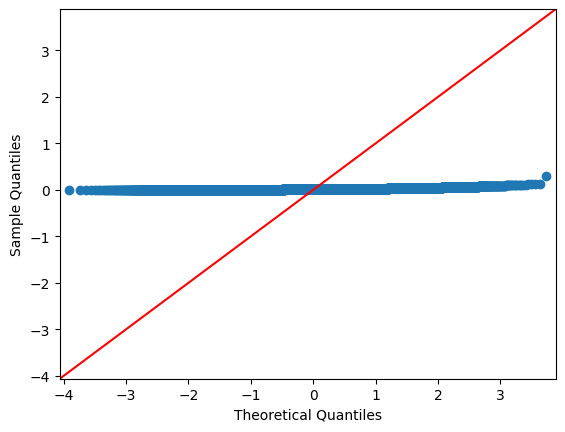

In [28]:
normal_test(true_df['cap_cnt_ratio']) # does not meet normality distribution as the datapoints do not locate on the diagonal red line

In [29]:
u_test(true_df, fake_df, 'cap_cnt_ratio')

no significance is observed


In [30]:
## total word count

In [31]:
u_test(true_df, fake_df, 'total_wd_cnt')

True and fake articles significantly differ in total_wd_cnt
